In [7]:
# Packages
library(ggplot2)  # visualization
library(dplyr)    # data manipulation
library(tidyr)    # reshape and clean data
library(forcats)  # working with factors

In [8]:
# Read the dataset and load it to a data frame
file_path <- "/content/CreditCardFraud_Dataset-4.csv"
df <- read.csv(file_path)
# Data transformations
df$MerchantID <- as.factor(df$MerchantID)         # Ensures proper grouping in plots/summaries
df$TransactionType <- as.factor(df$TransactionType)  # So ggplot doesn't treat it as text
df$Class <- factor(df$Class, levels = c("Normal", "Fraudulent"))  # So "Fraudulent" is the positive class

In [9]:
# Step 1: Create bin breaks starting from 1
bin_breaks <- seq(1, max(df$Amount, na.rm = TRUE) + 100, by = 100)
# Create labels
bin_labels <- paste0(bin_breaks[-length(bin_breaks)], "–", bin_breaks[-1] - 1)
# Apply bins
df <- df %>%
  mutate(Amount_Bin = cut(
    Amount,
    breaks = bin_breaks,
    labels = bin_labels,
    include.lowest = TRUE,
    right = TRUE  # include upper bound (e.g., 100 goes into "1–100")
  ))
# Step 2: Summarize fraud rate per bin
amount_fixed_bin_summary <- df %>%
  group_by(Amount_Bin, Class) %>%
  summarise(TransactionCount = n(), .groups = "drop") %>%
  tidyr::pivot_wider(
    names_from = Class,
    values_from = TransactionCount,
    names_prefix = "Class_",
    values_fill = 0
  ) %>%
  mutate(
    Total = Class_Fraudulent + Class_Normal,
    FraudRate = round(100 * Class_Fraudulent / Total, 2)
  ) %>%
  arrange(Amount_Bin)
# Step 3: Print it
print(amount_fixed_bin_summary)

# A tibble: 49 × 5
   Amount_Bin Class_Normal Class_Fraudulent Total FraudRate
   <fct>             <int>            <int> <int>     <dbl>
 1 1–100               970               22   992      2.22
 2 101–200             939               32   971      3.3 
 3 201–300             968               25   993      2.52
 4 301–400             951               26   977      2.66
 5 401–500            1015               23  1038      2.22
 6 501–600             958               21   979      2.15
 7 601–700             940               17   957      1.78
 8 701–800             952               19   971      1.96
 9 801–900             991               23  1014      2.27
10 901–1000            892               20   912      2.19
# ℹ 39 more rows


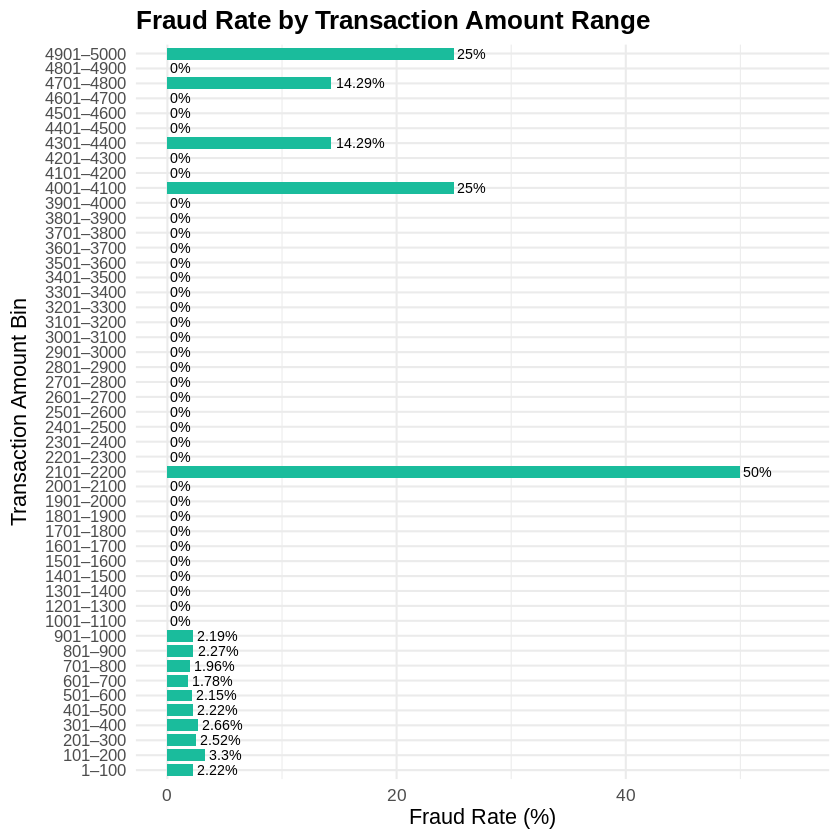

In [10]:
ggplot(amount_fixed_bin_summary, aes(y = Amount_Bin, x = FraudRate)) +
  geom_col(fill = "#1ABC9C", width = 0.8) +
  geom_text(aes(label = paste0(FraudRate, "%")), hjust = -0.1, size = 3) +
  labs(
    title = "Fraud Rate by Transaction Amount Range",
    x = "Fraud Rate (%)",
    y = "Transaction Amount Bin"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 10),
    plot.title = element_text(face = "bold")
  ) +
  coord_cartesian(xlim = c(0, max(amount_fixed_bin_summary$FraudRate, na.rm = TRUE) + 5))

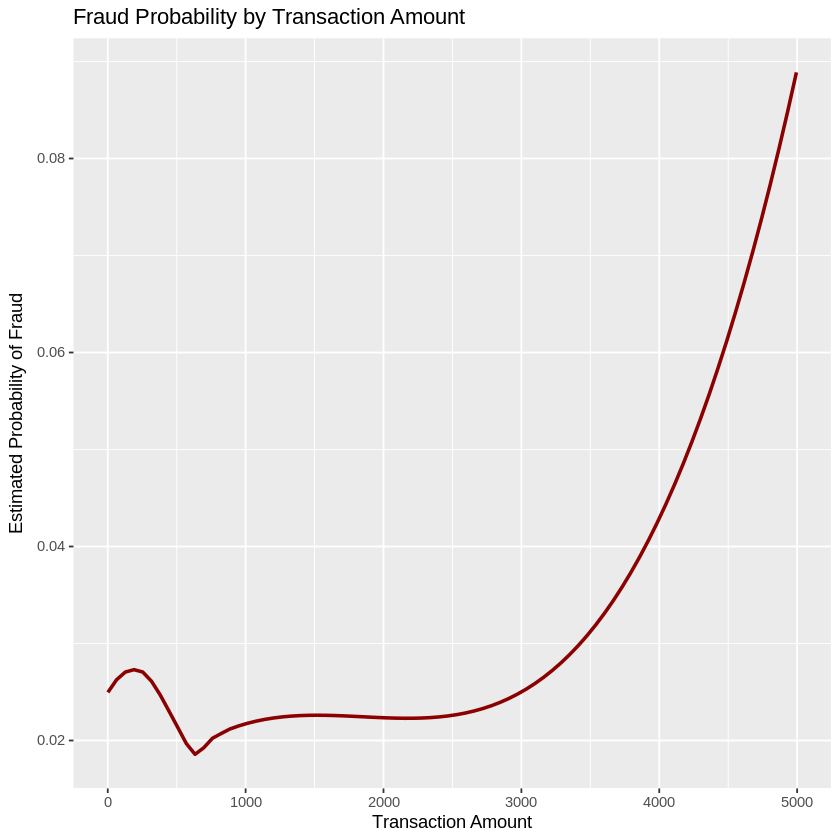

In [11]:
ggplot(df, aes(x = Amount, y = as.numeric(Class == "Fraudulent"))) +
  geom_smooth(method = "loess", formula = y ~ x, se = FALSE, color = "darkred") +
  labs(
    title = "Fraud Probability by Transaction Amount",
    x = "Transaction Amount",
    y = "Estimated Probability of Fraud"
  )

In [12]:
# Amount-Level Summary: Fraudulent vs Normal Transactions with Fraud Rate (%)
amount_summary <- df %>%
  group_by(Amount, Class) %>%
  summarise(TransactionCount = n(), .groups = "drop") %>%
  pivot_wider(
    names_from = Class,
    values_from = TransactionCount,
    names_prefix = "Class_",
    values_fill = 0
  ) %>%
  mutate(
    Total = Class_Fraudulent + Class_Normal,
    FraudRate = round(100 * Class_Fraudulent / Total, 2)
  ) %>%
  arrange(desc(FraudRate))
print(amount_summary)

# A tibble: 1,187 × 5
   Amount Class_Normal Class_Fraudulent Total FraudRate
    <int>        <int>            <int> <int>     <dbl>
 1   2110            0                1     1     100  
 2   4026            0                1     1     100  
 3   4358            0                1     1     100  
 4   4703            0                1     1     100  
 5   4903            0                1     1     100  
 6    189            4                2     6      33.3
 7    874            5                2     7      28.6
 8    929            5                2     7      28.6
 9    113            6                2     8      25  
10    263            6                2     8      25  
# ℹ 1,177 more rows


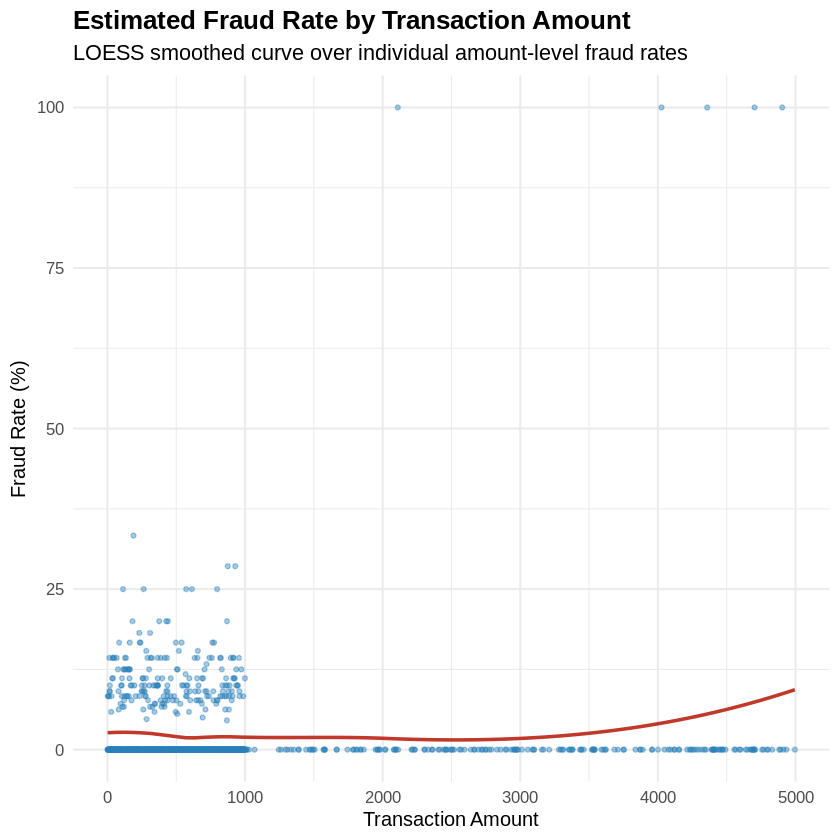

In [13]:
ggplot(amount_summary, aes(x = Amount, y = FraudRate)) +
  geom_point(alpha = 0.4, color = "#2980B9", size = 1) +
  geom_smooth(method = "loess", formula = y ~ x, color = "#C0392B", se = FALSE, linewidth = 1) +
  labs(
    title = "Estimated Fraud Rate by Transaction Amount",
    subtitle = "LOESS smoothed curve over individual amount-level fraud rates",
    x = "Transaction Amount",
    y = "Fraud Rate (%)"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold"),
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 12)
  )